# Cash Flow Forecasting:
ABC Finance Ltd is a finance institution who wants to check for their cash flow in December 2014. They have provided the records with transaction data and an excerpt from CRM with the customer data.
The situation will end on November 2014 and a forecast for the incoming payments in December 2014 is requested.
As an analyst, create a forecasting model to predict the cash flow for ABC Finance Ltd.
Let's start by reading in the data and examination of the data set.

In [145]:
#Import the libraries
import pandas as pd
import numpy as np

#Read the Bank Transaction Orders data
data = pd.read_csv('Orders.csv')

In [146]:
data.head()

,OrderID,CustomerID,OrderVolume,ShipMode,Segment,Category,PaymentTerm,Discount,ExistingPurchaseOrder,FirstCustomerOrder,CashInDate
0,O-100,1024,276.10,Same Day,Corporate,Office Supplies,30,5,Yes,Yes,18-02-2011
1,O-101,1024,35.88,Same Day,Corporate,Office Supplies,30,5,Yes,No,18-02-2011
2,O-102,1006,66.12,Second Class,Consumer,Office Supplies,30,3,Yes,Yes,06-02-2011
3,O-104,1023,408.30,Standard Class,Consumer,Office Supplies,30,5,No,Yes,17-02-2011
4,O-105,1009,314.22,Standard Class,Consumer,Technology,45,3,Yes,Yes,10-02-2011


In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37626 entries, 0 to 37625
Data columns (total 11 columns):
OrderID                  37626 non-null object
CustomerID               37626 non-null int64
OrderVolume              37617 non-null float64
ShipMode                 37626 non-null object
Segment                  37626 non-null object
Category                 37626 non-null object
PaymentTerm              37626 non-null int64
Discount                 37626 non-null int64
ExistingPurchaseOrder    37626 non-null object
FirstCustomerOrder       37626 non-null object
CashInDate               37626 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 3.2+ MB


Strangely, four columns of the type numeric. The rest is of the type object.

In [148]:
print('Rows, Columns:', data.shape)
print('Datatype Count:', data.dtypes.value_counts())


Rows, Columns: (37626, 11)
Datatype Count: object     7
int64      3
float64    1
dtype: int64


## CashInDate
First, We should transform the CashInDate column into the datetime type

In [149]:
from datetime import datetime, date
print(data.CashInDate[:10])
data.CashInDate = pd.to_datetime(data.CashInDate, format="%d-%m-%Y")
print(data.CashInDate[:10])

0    18-02-2011
1    18-02-2011
2    06-02-2011
3    17-02-2011
4    10-02-2011
5    09-02-2011
6    16-02-2011
7    09-02-2011
8    09-02-2011
9    19-02-2011
Name: CashInDate, dtype: object
0   2011-02-18
1   2011-02-18
2   2011-02-06
3   2011-02-17
4   2011-02-10
5   2011-02-09
6   2011-02-16
7   2011-02-09
8   2011-02-09
9   2011-02-19
Name: CashInDate, dtype: datetime64[ns]


Do we have missing data?

In [150]:
#Missing Values
print(data.shape)
data.isnull().sum()

(37626, 11)


OrderID                  0
CustomerID               0
OrderVolume              9
ShipMode                 0
Segment                  0
Category                 0
PaymentTerm              0
Discount                 0
ExistingPurchaseOrder    0
FirstCustomerOrder       0
CashInDate               0
dtype: int64

The size of the order, on the other hand, is very significant. Since there are only 9 records missing, I remove those lines.

In [151]:
data = data.dropna()
print(data.shape)

(37617, 11)


## Discount
Now let's look at the Discount column. Which values does this include?

In [152]:
data.Discount.value_counts()

5    18742
3     9438
0     9437
Name: Discount, dtype: int64

## Segment
Let's continue the investigation. What values does the Segment column have?

In [77]:
data.Segment.value_counts()

Consumer     19442
Corporate    18191
Name: Segment, dtype: int64

These are categorical data with two possible outputs. Replace this with 1 and 0.

In [153]:
#Convert it to 0 for Consumer and 1 for Corporate
data.Segment.replace(('Corporate', 'Consumer'), (1, 0), inplace=True)

## ExistingPurchaseOrder
Is there a sales order? Replace 'yes' with 1 and 'no' with 0.

In [154]:
#replaced 'Yes' and 'No' with 1 and 0
data.ExistingPurchaseOrder.replace(('Yes', 'No'), (1, 0), inplace=True)

## FirstCustomerOrder
And again, 'yes' replaced by 1 and 'no' by 0.

In [155]:
#Same game: replaced 'Yes' and 'No' with 1 and 0
data.FirstCustomerOrder.replace(('Yes', 'No'), (1, 0), inplace=True)

## DaysBetween
Define now our target column. The number of days between the invoice date and the receipt of the payment

In [156]:
#Define the new column with the month of Cash In:
data['Month'] = data.CashInDate.dt.month
print(data['Month'].value_counts())

12    4449
10    4368
11    3951
7     3636
9     3396
8     3277
1     3082
6     2668
5     2391
4     2233
2     2214
3     1952
Name: Month, dtype: int64


## MaxFlow and MinFlow
December has maximum flow and March has least

In [157]:
print(data.ShipMode.value_counts())
print(data.Category.value_counts())

Standard Class    22520
Second Class       7566
First Class        5546
Same Day           1985
Name: ShipMode, dtype: int64
Office Supplies    22910
Technology          7533
Furniture           7174
Name: Category, dtype: int64


## ShipMode and Category
These columns contain categorical data with multiple possibilities. I will do this later with the help of hot-one-coding.

## OrderID
This column does not contribute to the model and will be removed later

## Customer
Contains the information as CustomerID in terms of this use case. I remove these too.

In [190]:
ts = pd.DataFrame(data.groupby(by=['CashInDate'])['OrderVolume'].agg('sum'))
ts = ts['OrderVolume']
print(ts.index)
print(ts.head)

DatetimeIndex(['2011-01-18', '2011-01-19', '2011-01-20', '2011-01-22',
               '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27',
               '2011-01-28', '2011-01-29',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='CashInDate', length=1441, freq=None)
<bound method NDFrame.head of CashInDate
2011-01-18      324.45
2011-01-19       31.20
2011-01-20      565.48
2011-01-22      149.95
2011-01-24      554.37
                ...   
2014-12-27     8385.38
2014-12-28     7744.90
2014-12-29    12145.36
2014-12-30    13026.09
2014-12-31     4576.25
Name: OrderVolume, Length: 1441, dtype: float64>


In [191]:
ts = ts.asfreq('D')
ts = ts.fillna(method='ffill')
print(ts.shape)

(1444,)


In [192]:
ts.head(10)
print(ts['2014'])
print(ts['2014-01'])
ts2014 = ts['2014']

CashInDate
2014-01-01     7825.22
2014-01-02    12000.11
2014-01-03     6752.87
2014-01-04     6711.49
2014-01-05     8175.26
                ...   
2014-12-27     8385.38
2014-12-28     7744.90
2014-12-29    12145.36
2014-12-30    13026.09
2014-12-31     4576.25
Freq: D, Name: OrderVolume, Length: 365, dtype: float64
CashInDate
2014-01-01     7825.22
2014-01-02    12000.11
2014-01-03     6752.87
2014-01-04     6711.49
2014-01-05     8175.26
2014-01-06    11610.64
2014-01-07     8862.72
2014-01-08    13330.59
2014-01-09    12190.71
2014-01-10     8643.80
2014-01-11     7635.12
2014-01-12    11045.95
2014-01-13     7147.70
2014-01-14    11427.81
2014-01-15    13504.20
2014-01-16     5934.17
2014-01-17     7198.07
2014-01-18     4169.68
2014-01-19     5556.05
2014-01-20     9698.89
2014-01-21     9846.65
2014-01-22     9078.46
2014-01-23    19786.47
2014-01-24    12002.20
2014-01-25     6907.12
2014-01-26     7920.81
2014-01-27     3918.71
2014-01-28     9707.72
2014-01-29     8103.96
20

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

Checking the stationarity

What is stationary process?
* Mean = constant over all intervals.
* Variance = constant over all intervals.

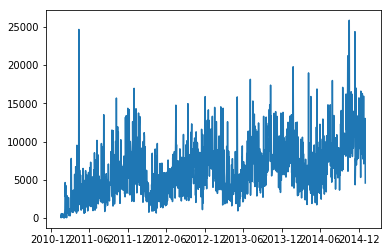

In [194]:
plt.plot(ts)

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

* Constant mean
* Constant variance
* An autocovariance that does not depend on time.

<b>Plotting Rolling Statistics:</b> We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

<b>Dickey-Fuller Test:</b> This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ```Test Statistic``` is less than the ```Critical Value```, we can reject the null hypothesis and say that the series is stationary.

In [210]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


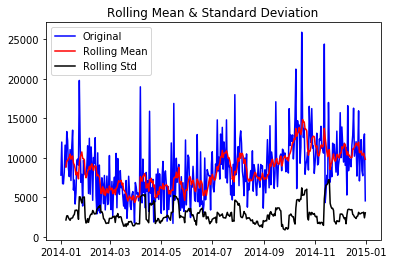

Results of Dickey-Fuller Test:
Test Statistic                  -2.221684
p-value                          0.198470
#Lags Used                       9.000000
Number of Observations Used    355.000000
Critical Value (1%)             -3.448906
Critical Value (5%)             -2.869716
Critical Value (10%)            -2.571126
dtype: float64


In [211]:
test_stationarity(ts2014)

Therefore, the time series is not stationary.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.


To eliminate **trend** we will apply a transformation that makes the values more or less same, ie. we use log

#### One way to eliminate trend (that doesn't always work)

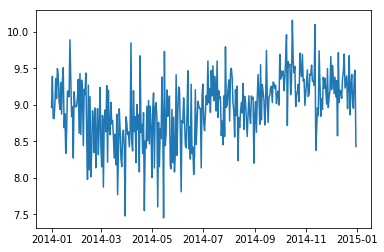

In [212]:
ts2014_log = np.log(ts2014)
plt.plot(ts2014_log)

We will deal with the noise by taking rolling mean i.e. smoothing

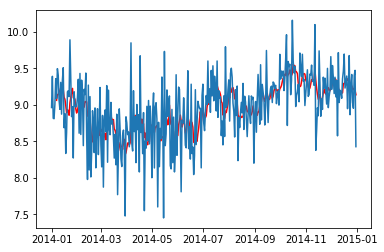

In [213]:
ts2014_smooth = ts2014_log.rolling(window = 7).mean()
plt.plot(ts2014_smooth, color = 'red')
plt.plot(ts2014_log)
plt.show()

In [214]:
# Case 1: No subtraction
no_sub_ts2014 = ts2014_smooth
no_sub_ts2014.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts2014 = ts2014_log - ts2014_smooth
sub_ts2014.dropna(inplace = True)

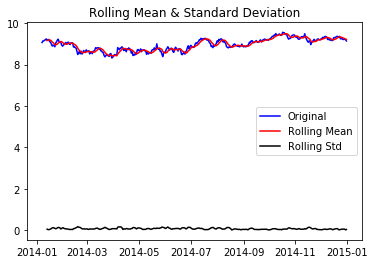

Results of Dickey-Fuller Test:
Test Statistic                  -1.234186
p-value                          0.658720
#Lags Used                      14.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64


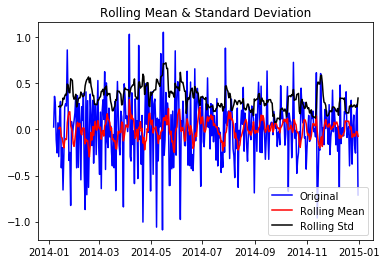

Results of Dickey-Fuller Test:
Test Statistic                -1.023200e+01
p-value                        5.000544e-18
#Lags Used                     6.000000e+00
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64


In [215]:
# Perform Dickey-Fuller on both
test_stationarity(no_sub_ts2014)
test_stationarity(sub_ts2014)

Exponential weighted average instead of rolling average

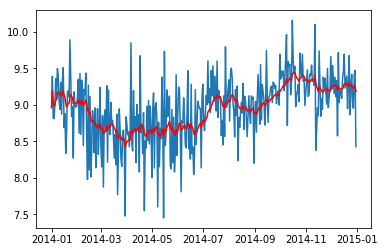

In [216]:
expwighted_avg = ts2014_log.ewm(halflife=7).mean()
plt.plot(ts2014_log)
plt.plot(expwighted_avg, color='red')

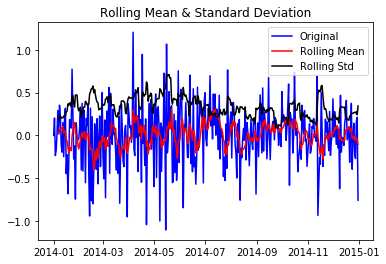

Results of Dickey-Fuller Test:
Test Statistic                 -21.889422
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


In [217]:
exp_ts2014_diff = ts2014_log-expwighted_avg
test_stationarity(exp_ts2014_diff)

Since test statistic is lower than 1% critical value, it means that we are 99% sure that we have a stationary series.

Other ways of eliminating trend and seasonality,
* Differencing
* Decomposition

**Differencing**

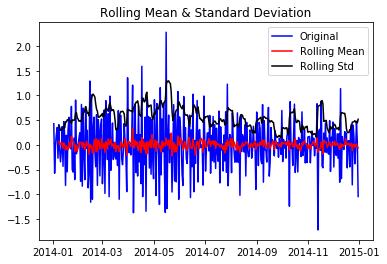

Results of Dickey-Fuller Test:
Test Statistic                -8.939566e+00
p-value                        9.332708e-15
#Lags Used                     1.200000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


In [218]:
ts2014_diff = ts2014_log - ts2014_log.shift()
ts2014_diff.dropna(inplace = True)

test_stationarity(ts2014_diff)

How about differencing + exponential weighting?

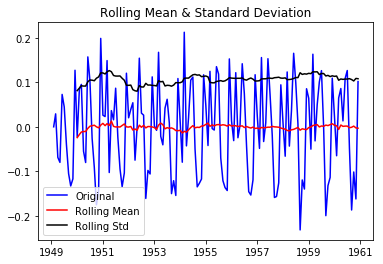

Results of Dickey-Fuller Test:
Test Statistic                  -4.067811
p-value                          0.001094
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (5%)             -2.884219
Critical Value (1%)             -3.482088
Critical Value (10%)            -2.578864
dtype: float64


In [99]:
ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
ts_diff_exp.dropna(inplace = True)
test_stationarity(ts_diff_exp)

Great! We got confidence of 99%. 

** Decomposition **

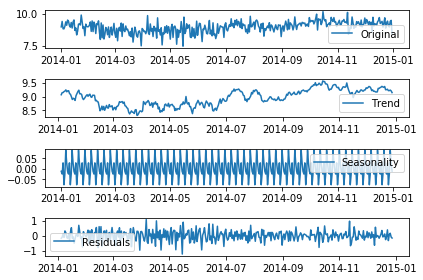

In [219]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2014_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts2014_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

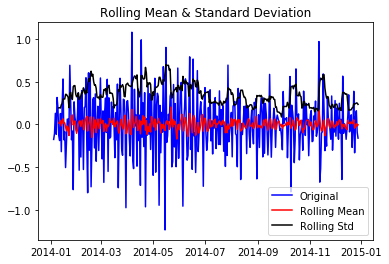

Results of Dickey-Fuller Test:
Test Statistic                -8.928149e+00
p-value                        9.982299e-15
#Lags Used                     1.700000e+01
Number of Observations Used    3.410000e+02
Critical Value (1%)           -3.449673e+00
Critical Value (5%)           -2.870053e+00
Critical Value (10%)          -2.571306e+00
dtype: float64


In [220]:
ts2014_log_decompose = residual
ts2014_log_decompose.dropna(inplace=True)
test_stationarity(ts2014_log_decompose)

### Forecasting

Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
2. A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Let me give you a brief introduction to ARIMA. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.



**Selecting p, q, and d values**
1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


In [223]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [224]:
lag_acf = acf(ts2014_diff, nlags=7)
lag_pacf = pacf(ts2014_diff, nlags=7, method='ols')

C:\Users\ab275\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Partial Autocorrelation Function')

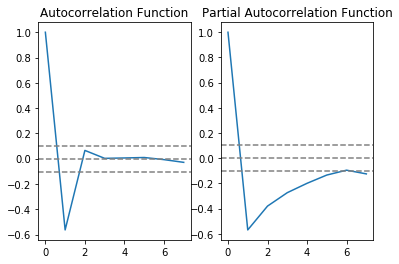

In [225]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts2014_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts2014_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts2014_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts2014_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

p = 5, q = 1

Now AR, MA & ARIMA models for the data

In [226]:
from statsmodels.tsa.arima_model import ARIMA

AR model

Text(0.5,1,'RSS: 76.9024')

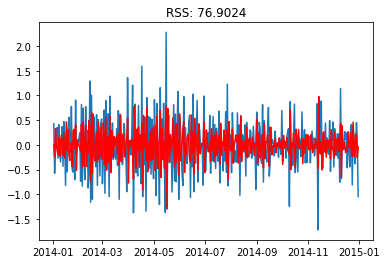

In [271]:
model = ARIMA(ts2014_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts2014_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts2014_diff)**2))

Text(0.5,1,'RSS: 54.8437')

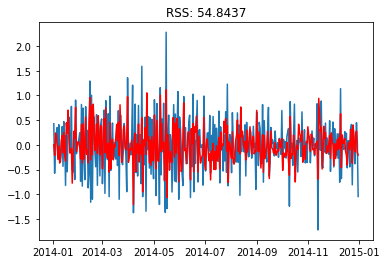

In [272]:
# MA model
model = ARIMA(ts2014_log, order=(0, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(ts2014_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts2014_diff)**2))

Text(0.5,1,'RSS: 53.7027')

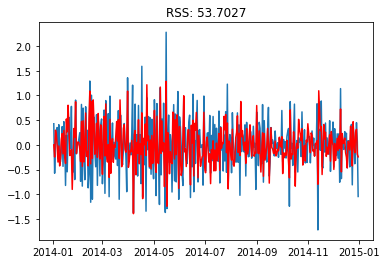

In [273]:
# ARIMA model
model = ARIMA(ts2014_log, order=(1, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(ts2014_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts2014_diff)**2))

# Taking it back to the original scale
Lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [274]:
preds = pd.Series(results_AR.fittedvalues, copy = True)
preds_cumsum = preds.cumsum()
print(preds_cumsum.head())

CashInDate
2014-01-02    0.000281
2014-01-03   -0.245742
2014-01-04    0.051545
2014-01-05    0.271627
2014-01-06    0.258438
Freq: D, dtype: float64


In [275]:
preds_log = pd.Series(ts2014_log[0], index=ts2014_log.index)
preds_log = preds_log.add(preds_cumsum,fill_value=0)
preds_log.head()

CashInDate
2014-01-01    8.965107
2014-01-02    8.965388
2014-01-03    8.719365
2014-01-04    9.016652
2014-01-05    9.236734
Freq: D, dtype: float64

Text(0.5,1,'RMSE: 9043.6615')

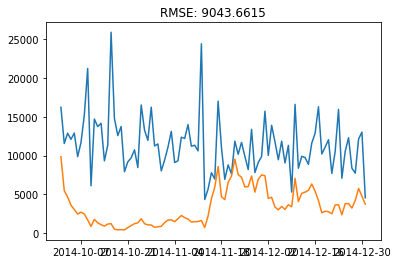

In [292]:
preds_ARIMA = np.exp(preds_log)
plt.plot(ts2014['2014-10':])
plt.plot(preds_ARIMA['2014-10':])
plt.title('RMSE: %.4f'% np.sqrt(sum((preds_ARIMA['2014-10':]-ts2014['2014-10':])**2)/len(ts2014['2014-10':])))